## Parameters

In [1]:
train_batch_size = 64
val_batch_size = 32
num_workers = 4

num_epochs = 40

learning_rate = 0.001 # in some cases - start learning rate

log_dir = './logs'
train_file = 'sign-language-mnist/sign_mnist_train.csv'
test_file = 'sign-language-mnist/sign_mnist_test.csv'

In [3]:
import pandas as pd
import torch
from torch.utils.tensorboard import SummaryWriter

## Лабораторная №6

### Задание 1.
#### Загрузите данные. Разделите исходный набор данных на обучающую и валидационную выборки.


In [4]:
train_csv = pd.read_csv(train_file)
test_csv = pd.read_csv(test_file)

In [5]:
train_csv.iloc[:, 0].describe()

count    27455.000000
mean        12.318813
std          7.287552
min          0.000000
25%          6.000000
50%         13.000000
75%         19.000000
max         24.000000
Name: label, dtype: float64

### Задание 2.
#### Реализуйте глубокую нейронную сеть со сверточными слоями. Какое качество классификации получено? Какая архитектура сети была использована?

In [6]:
from data_loader import SignLanguageDataset
from torch.utils.data import DataLoader
from torchvision import transforms

# train data
tfms = transforms.Compose([transforms.ToTensor()])
train_dataset = SignLanguageDataset(train_csv, transforms=tfms)
train_loader = DataLoader(train_dataset, num_workers=num_workers, batch_size=train_batch_size, shuffle=True)

# test data
test_tfms = transforms.Compose([transforms.ToTensor()])
test_dataset = SignLanguageDataset(test_csv, transforms=test_tfms)
test_loader = DataLoader(test_dataset, num_workers=num_workers, batch_size=val_batch_size, shuffle=False)

In [7]:
from cnn_model import CNNModel
import torch.nn as nn


model = CNNModel()
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
logs_writer = SummaryWriter(log_dir='./logs/simple-cnn')

In [8]:
from train_loop import train

train(model, train_loader, test_loader, num_epochs, 
    optimizer, criterion, logs_writer)

100%|██████████| 40/40 [18:12<00:00, 27.32s/it]


### Задание 3.
#### Примените дополнение данных (data augmentation). Как это повлияло на качество классификатора?

In [9]:
from data_loader import SignLanguageDataset
from torch.utils.data import DataLoader
from torchvision import transforms


tfms = transforms.Compose([
        transforms.ToPILImage(mode=None),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomPerspective(distortion_scale=0.5, p=0.5, interpolation=3),
        transforms.ToTensor(),
    ])

# train data
train_dataset = SignLanguageDataset(train_csv, transforms=tfms)
train_loader = DataLoader(train_dataset, num_workers=num_workers, batch_size=train_batch_size, shuffle=True)

# test data
test_tfms = transforms.Compose([transforms.ToTensor()])
test_dataset = SignLanguageDataset(test_csv, transforms=test_tfms)
test_loader = DataLoader(test_dataset, num_workers=num_workers, batch_size=val_batch_size, shuffle=False)

In [10]:
from cnn_model import CNNModel
import torch.nn as nn


model = CNNModel()
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
logs_writer = SummaryWriter(log_dir='./logs/simple-cnn-augmentations')

In [11]:
from train_loop import train

train(model, train_loader, test_loader, num_epochs, 
    optimizer, criterion, logs_writer)

100%|██████████| 40/40 [18:43<00:00, 28.09s/it]


### Задание 4.
#### Поэкспериментируйте с готовыми нейронными сетями (например, AlexNet, VGG16, Inception и т.п.), применив передаточное обучение. Как это повлияло на качество классификатора? Можно ли было обойтись без него? Какой максимальный результат удалось получить на контрольной выборке?


In [12]:
from data_loader import SignLanguageDataset
from torch.utils.data import DataLoader
from torchvision import transforms


tfms = transforms.Compose([
        transforms.ToPILImage(mode=None),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomPerspective(distortion_scale=0.5, p=0.5, interpolation=3),
        transforms.ToTensor(),
    ])

# train data
train_dataset = SignLanguageDataset(train_csv, transforms=tfms)
train_loader = DataLoader(train_dataset, num_workers=num_workers, batch_size=train_batch_size, shuffle=True)

# test data
test_tfms = transforms.Compose([transforms.ToTensor()])
test_dataset = SignLanguageDataset(test_csv, transforms=test_tfms)
test_loader = DataLoader(test_dataset, num_workers=num_workers, batch_size=val_batch_size, shuffle=False)

In [13]:
from torchvision import models
from torch.optim import lr_scheduler


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 25)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.AdamW(model_ft.parameters(), lr=learning_rate)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.CosineAnnealingLR(optimizer_ft, 60)

logs_writer = SummaryWriter(log_dir='./logs/resnet18-augmentations')

In [14]:
from train_loop import train

train(model, train_loader, test_loader, num_epochs, 
    optimizer, criterion, logs_writer)

100%|██████████| 40/40 [18:37<00:00, 27.93s/it]


In [15]:
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 25)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.AdamW(model_ft.parameters(), lr=learning_rate)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.CosineAnnealingLR(optimizer_ft, 60)

logs_writer = SummaryWriter(log_dir='./logs/resnet50-augmentations')

In [16]:
from train_loop import train

train(model, train_loader, test_loader, num_epochs, 
    optimizer, criterion, logs_writer)

100%|██████████| 40/40 [19:12<00:00, 28.82s/it]


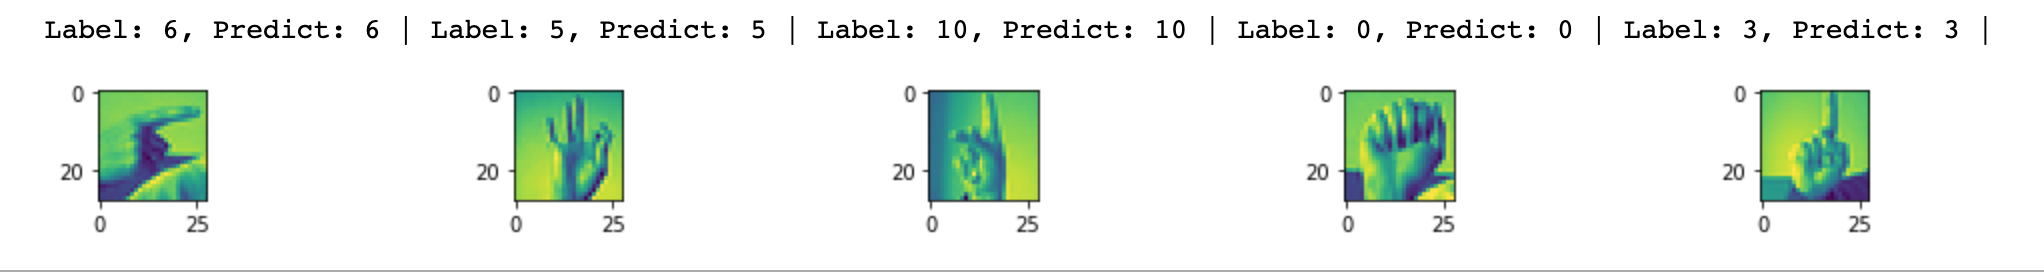

In [3]:
from IPython.display import Image
Image(filename='images/Examples.png') 

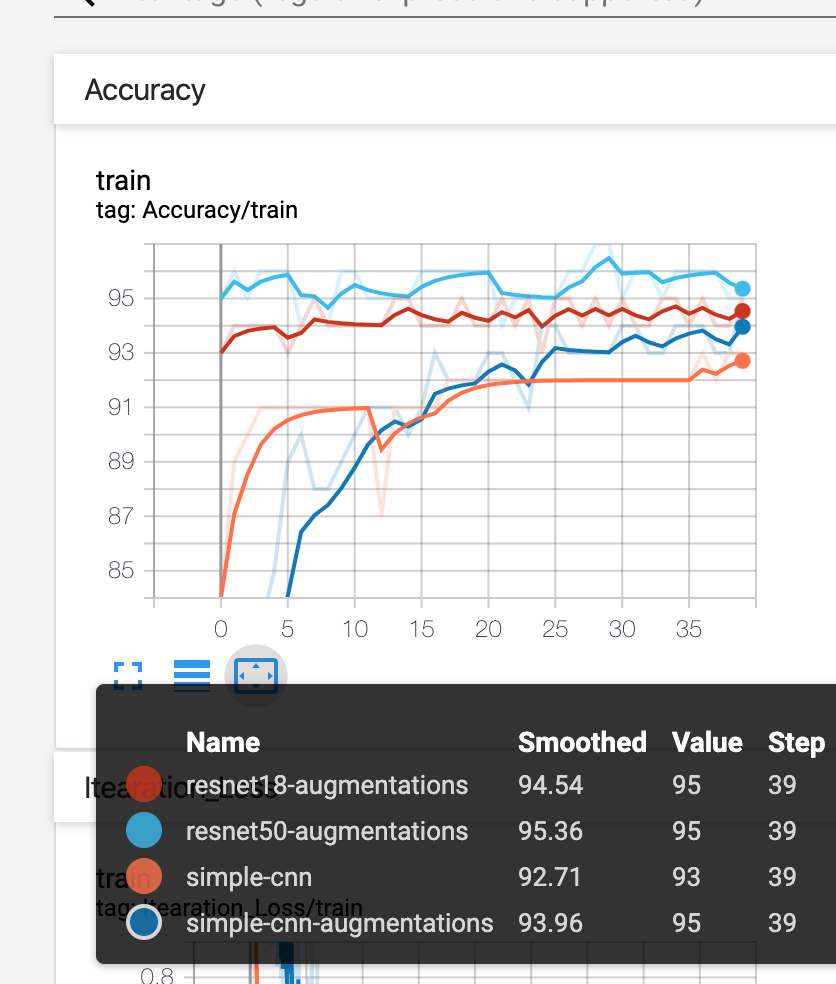

In [2]:
from IPython.display import Image
Image(filename='images/Accuracy.png') 